In [1]:
#!git clone https://github.com/zigolox/importance-weighted-autoencoders.git
#%cd "importance-weighted-autoencoders/"

In [2]:
%%capture
!pip install --upgrade einops optax equinox distrax jaxopt

In [3]:
from jax import numpy as jnp
from jax import random, value_and_grad, lax
from optax import adam, apply_updates, chain, clip, softmax_cross_entropy_with_integer_labels
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax import lax, vmap, checkpoint
from distrax import Normal, Bernoulli
from jax.nn import gelu, sigmoid
from jax import disable_jit
from jaxopt import FixedPointIteration



# Typing 
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)

In [14]:
def normalize_img(omni,_):
    """Normalizes images: `uint8` -> `float32`."""
    x = rearrange(omni["image"], "h w c -> c h w")
    return {'alphabet': omni["alphabet"],
    'alphabet_char_id': omni["alphabet_char_id"],
    'image': omni["image"],
    'label': omni["label"] }


# Load the dataset
#train, test = tfds.load("omniglot", split=["train","test"], data_dir="data", as_supervised=True)
train, test = tfds.load("mnist", split=["train","test"], data_dir="data", as_supervised=True)

#train = train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train_img, train_labels = [jnp.array(i)[:6000] for i in list(zip(*train.as_numpy_iterator()))]
train_img /= 255
#test = test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_img, test_labels = [jnp.array(i)[:6000] for i in list(zip(*test.as_numpy_iterator()))]
test_img /= 255




Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to data/mnist/3.0.1. Subsequent calls will reuse this data.


In [41]:
def batch_loss(model, images: Array, labels: Array) -> Array:
    '''Compute the loss.'''

    def loss(image: Array, label: Array):
        pred = model(image.ravel())

        #return jnp.linalg.norm(pred-label)**2/len(pred)

        return  softmax_cross_entropy_with_integer_labels(pred,label)

    # Mean over the batch
    return vmap(loss)(images, labels).mean()

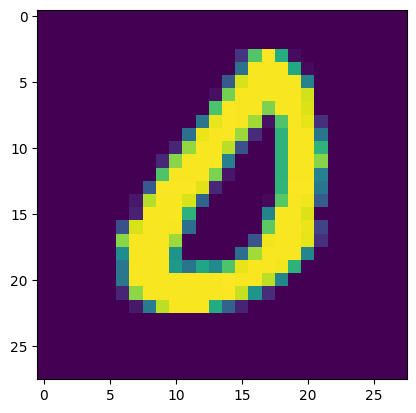

In [51]:
import matplotlib.pyplot as plt
# Choose simple image to predict
train_image = train_img[2]
plt.imshow(train_image)
plt.show()

In [43]:
epochs = 80
batch_size = 100

# Initialize the model
#model = eqx.nn.MLP(3*105**2,1623,5000,2,key=MODEL_KEY)
model = eqx.nn.MLP(1*28**2,10,5000,2,key=MODEL_KEY)
# Initialize the optimizer
optim = adam(3e-5, eps=1e-04)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# Training step function
@eqx.filter_jit
def step(model, opt_state, image, labels):
    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, image, labels)
    updates, opt_state = optim.update(grad, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

In [44]:
# Train the model

pbar = tqdm(random.split(MODEL_KEY,epochs),total=epochs)
for key in pbar:
    perm = random.permutation(key,jnp.arange(len(train_labels)))
    train_img_perm = train_img[perm]
    batched_img = rearrange(train_img_perm, "(l b) h w c -> l b h w c",b=batch_size)
    del train_img_perm
    train_labels_perm = train_labels[perm]
    batched_labels = rearrange(train_labels_perm, "(l b) -> l b",b=batch_size)
    del train_labels_perm
    for image,labels in zip(batched_img,batched_labels):
        model,opt_state, loss = step(model, opt_state, image, labels)
        pbar.set_postfix({'loss': f'{loss.mean():.3}'})

  0%|          | 0/80 [00:00<?, ?it/s]

In [52]:
jnp.argmax(sigmoid(model(train_img[2].ravel())))

Array(0, dtype=int32)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(Bernoulli(logits=model(seed_image,max_steps,key=MODEL_KEY)[0][0]).mean())

In [ ]:
    @eqx.filter_jit
    def scan_step(carry,it):
        params, opt_state = carry
        x, key = it
        model = eqx.combine(params,static)
        model, opt_state, loss = step(model,opt_state,x,key)
        return (eqx.filter(model,eqx.is_array),opt_state), loss
